In [1]:
import pandas as pd
from classifiers import *
from UMAP import *
from sklearn.datasets import load_digits
from scipy.stats import pearsonr

# from mnist.loader import MNIST

def get_non_significant_features(dataframe, label_to_predict, all_labels):
    # Remove all labels except the one to predict
    cols_to_remove = set(all_labels) - {label_to_predict}
    dataframe = dataframe.drop(columns=cols_to_remove, errors='ignore')
    
    non_significant_feats = []
    for feature in dataframe.columns:
        if feature != label_to_predict:
            _, p_value = pearsonr(dataframe[feature], dataframe[label_to_predict])
            if p_value >= 0.05:
                non_significant_feats.append(feature)
    return non_significant_feats


'''gets all of the poorly correlated features. they have a pearson correlation that is less than the threshold'''
def get_low_correlation_features(dataset, label_to_predict, all_labels, threshold):
    features = dataset.drop(columns=all_labels, errors='ignore')
    if label_to_predict in features:
        features = features.drop(columns=label_to_predict)
    
    low_correlation_features = []
    
    for feature in features.columns:
        correlation, _ = pearsonr(dataset[feature], dataset[label_to_predict])
        if abs(correlation) < threshold:
            low_correlation_features.append(feature)
            
    return low_correlation_features

/Users/jakehirst/miniconda3/envs/tfp_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 1797
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

/Users/jakehirst/miniconda3/envs/tfp_env/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


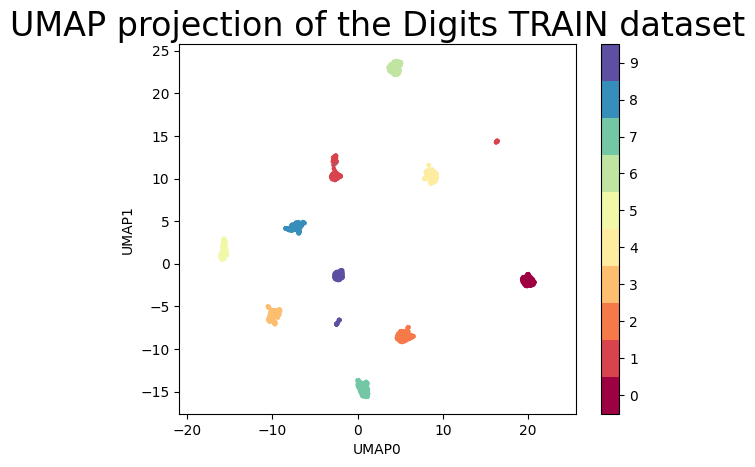

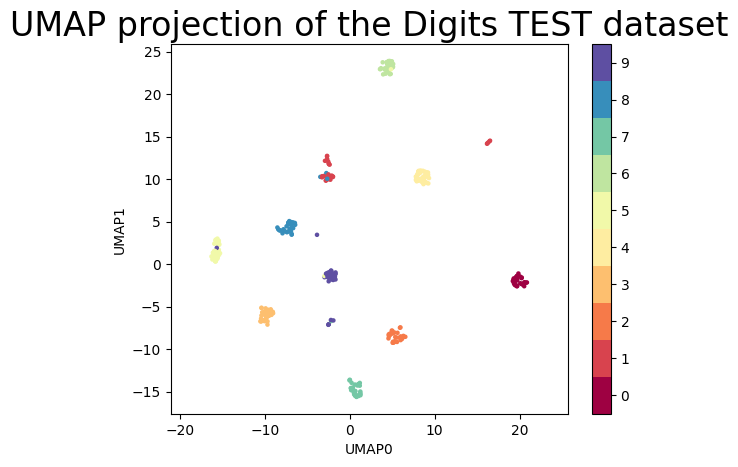

In [2]:
digits = load_digits()
print(digits.DESCR)

X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.2, random_state=42)

mapper = umap.UMAP(n_components=2, random_state=42).fit(X_train, y=y_train)
train_embedding = mapper.transform(X_train)
test_embedding = mapper.transform(X_test)


plt.scatter(train_embedding[:, 0], train_embedding[:, 1], c=y_train, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of the Digits TRAIN dataset', fontsize=24)
plt.xlabel('UMAP0')
plt.ylabel('UMAP1')
plt.show()       

plt.scatter(test_embedding[:, 0], test_embedding[:, 1], c=y_test, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of the Digits TEST dataset', fontsize=24)
plt.xlabel('UMAP0')
plt.ylabel('UMAP1')
plt.show()   


In [15]:
all_labels = ['height', 'phi', 'theta', 
                'impact site x', 'impact site y', 'impact site z', 
                'impact site r', 'impact site phi', 'impact site theta']

label = 'height'

# top ten features for height from RF model
top_10_features = ['abs_val_sum_kink * mean thickness',
                    'abs_val_sum_kink / avg_prop_speed',
                    'abs_val_sum_kink / thickness_at_init',
                    'abs_val_sum_kink + init y',
                    'crack len + init y',
                    'crack len (unchanged)',
                    'dist btw frts + init y',
                    'abs_val_sum_kink - avg_prop_speed',
                    'avg_prop_speed - abs_val_sum_kink',
                    'abs_val_sum_kink - init z',
                    'init z - abs_val_sum_kink']

dataset_path = '/Volumes/Jake_ssd/feature_datasets/feature_transformations_2023-11-05/height/HEIGHTALL_TRANSFORMED_FEATURES.csv'
# dataset_path = '/Users/jakehirst/Desktop/sfx/sfx_ML_data/New_Crack_Len_FULL_OG_dataframe_2023_11_06.csv'
df = pd.read_csv(dataset_path)

'''getting a list of all of the features'''
feature_set = df.drop(all_labels, axis=1)
# feature_candidates = feature_set.columns.to_list() #all of the features that will be considered
all_features = feature_set.columns.to_list() #all of the features that will be considered
all_features = [string for string in all_features if 'timestep_init' not in string]


'''remove all of the features that do not have a p-value of less than 0.05 with the label. this is the first filter... '''
non_significant_features = get_non_significant_features(df, label, all_labels)
kept_features = [item for item in all_features if item not in non_significant_features]
'''remove all of the features that do not have a correlation above 0.2 with the label. this is the second filter... '''
low_correlated_features = get_low_correlation_features(df[kept_features + all_labels], label, all_labels, 0.2)
kept_features = [item for item in kept_features if item not in low_correlated_features]

print(df.shape)
df = df[kept_features + all_labels]
print(df.shape)
'''clean the data from bad columns'''
#removing all columns that have timestep_init or Unnamed in them
df = df.filter(regex='^(?!.*timestep_init|.*Unnamed).*$') 
#remove all columsn that have values not suitable for float32s
df = remove_unworthy_columns(df)

''' adding clustered initiation sites to the dataframe '''
# clusters = cluster_coordinates(df, 'init x (unchanged)', 'init y (unchanged)', num_clusters=5)
# clusters = cluster_coordinates(df, 'init x', 'init y', num_clusters=5)
# df = add_clusters_to_df(df, clusters)

'''bin the labels'''
bin_edges = [1, 2, 3, 4, 5]
# bin_edges = [1,2.5,5]

label_df = df[all_labels]
binned_heights = bin_labels(bin_edges, label_df, label)

'''normalize the data'''
feature_df = df.drop(all_labels, axis=1)
# Initialize the StandardScaler
scaler = StandardScaler()
# Fit the scaler to the features and transform (normalize and zero-center)
features_scaled = scaler.fit_transform(feature_df)
# The scaler returns a NumPy array, so let's convert it back to a DataFrame
df_normalized = pd.DataFrame(features_scaled, columns=feature_df.columns)
feature_df = df_normalized



'''split into a train/test split'''
X_train, X_test, y_train, y_test = train_test_split(feature_df, binned_heights, test_size=0.2, random_state=42)

print(f'train feature_df.shape = {X_train.shape}')
print(f'test feature_df.shape {X_test.shape}')
print(f'y_train.shape = {y_train.shape}')
print(f'first 10 binned_heights = {y_train[0:10]}')

# args = ('euclidean', 50, 0.9)

# mapper = umap.UMAP(n_components=20, 
#                    metric=args[0],
#                    n_neighbors=args[1],
#                    min_dist = args[2],
#                    random_state=42).fit(feature_df.to_numpy())

# embedding = mapper.transform(feature_df)
# embedding_df = pd.DataFrame(embedding, columns=[f'UMAP{i}' for i in range(embedding.shape[1])])
# embedding_df['height'] = label_df['height']
# embedding_df.to_csv('/Users/jakehirst/Desktop/UMAP_EMBEDDING.csv')
# correlation = embedding_df.corr()
# print(correlation['height'])
        

(298, 741)
(298, 268)
train feature_df.shape = (238, 259)
test feature_df.shape (60, 259)
y_train.shape = (238,)
first 10 binned_heights = [0 2 2 1 0 0 3 0 2 3]


/Users/jakehirst/miniconda3/envs/tfp_env/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP0     0.404032
UMAP1     0.377070
UMAP2     0.424030
UMAP3     0.403521
UMAP4    -0.104118
UMAP5    -0.408814
UMAP6     0.422707
UMAP7    -0.063280
UMAP8     0.430861
UMAP9     0.276822
UMAP10   -0.033750
UMAP11    0.366476
UMAP12    0.403838
UMAP13   -0.372215
UMAP14   -0.379340
UMAP15   -0.288868
UMAP16   -0.430947
UMAP17    0.344835
UMAP18    0.406176
UMAP19   -0.400661
height    1.000000
Name: height, dtype: float64


/Users/jakehirst/miniconda3/envs/tfp_env/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(238, 259)
(60, 259)


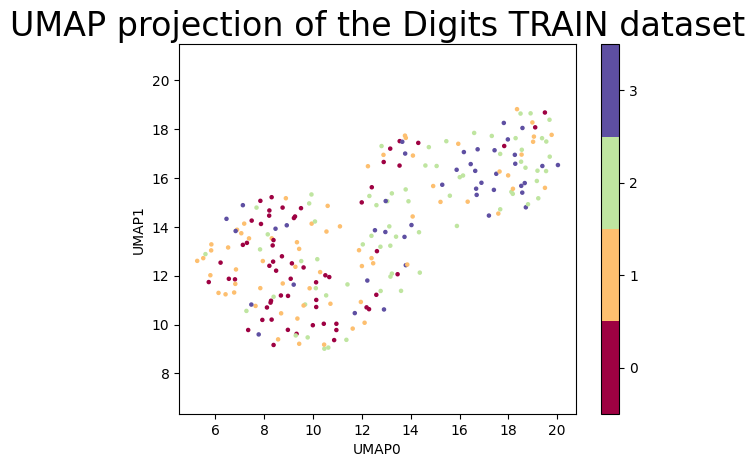

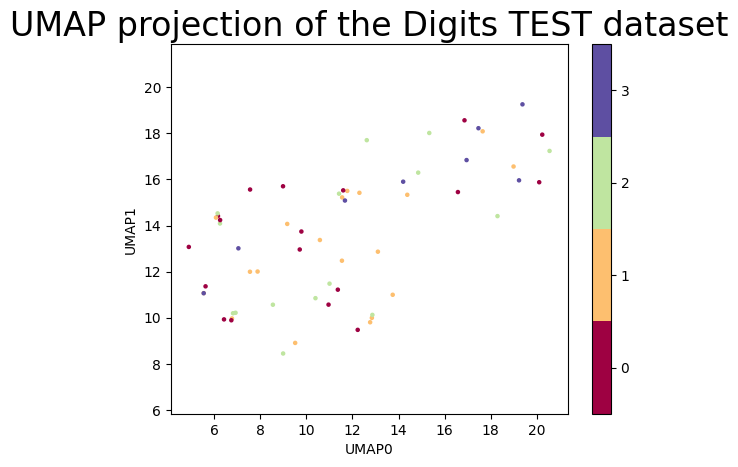

In [10]:
'''2 UMAP components - 2D plots'''
args = ('euclidean', 50, 0.9)

mapper = umap.UMAP(n_components=2, 
                   metric=args[0],
                   n_neighbors=args[1],
                   min_dist = args[2],
                   random_state=42).fit(X_train, y=y_train)

train_embedding = mapper.transform(X_train)
test_embedding = mapper.transform(X_test)
print(X_train.shape)
print(X_test.shape)

# plt.figure(figsize=(15,10))
plt.scatter(train_embedding[:, 0], train_embedding[:, 1], c=y_train, cmap='Spectral', s=5)
# plt.scatter(train_embedding[:, 0], train_embedding[:, 1], c=y_train, cmap='Spectral', s=15, marker="o", label='training set')
# plt.scatter(test_embedding[:, 0], test_embedding[:, 1], c=y_test, cmap='Spectral', s=20, marker='^', label='testing set')
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(5)-0.5).set_ticks(np.arange(4))
plt.title('UMAP projection of the Digits TRAIN dataset', fontsize=24)
plt.xlabel('UMAP0')
plt.ylabel('UMAP1')
# plt.legend()

plt.show()       

plt.scatter(test_embedding[:, 0], test_embedding[:, 1], c=y_test, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(5)-0.5).set_ticks(np.arange(4))
plt.title('UMAP projection of the Digits TEST dataset', fontsize=24)
plt.xlabel('UMAP0')
plt.ylabel('UMAP1')
plt.show()   

In [28]:
'''3 UMAP components - 3D plots'''

'''perform umap on the training dataset, and keep the mapper so we can use it on the test dataset'''
results_path = '/Volumes/Jake_ssd/UMAP/classficiation/figures/4_bins_feature_transformation_dataset'
if(not os.path.exists(results_path)): os.makedirs(results_path)

args = ('euclidean', 100, 0.1)

mapper = umap.UMAP(n_components=3, 
                   metric=args[0],
                   n_neighbors=args[1],
                   min_dist = args[2],
                   random_state=42).fit(X_train)

train_embedding = mapper.transform(X_train)
test_embedding = mapper.transform(X_test)
test_embedding = mapper.transform(X_test.to_numpy()) 




max_int = int(y_train.max()) + 1
# Create a discrete color scale at the middle point between integers
colorscale = [
    # Color changes between the range of each integer, i.e., [1, 2), [2, 3)
    [(i - 0.5) / max_int, 'color_for_integer_{}'.format(i)] for i in range(max_int)
]
# Assuming 'embedding' and 'binned_heights_array' are your data
trace1 = go.Scatter3d(
    x=train_embedding[:, 0],
    y=train_embedding[:, 1],
    z=train_embedding[:, 2],
    mode='markers',
    marker=dict(
        size=4,
        color=y_train,   # set color to an array/list of desired values
        colorscale='Spectral',        # choose a colorscale
        opacity=1,
        cmin=-0.5,                        # starting color min at -0.5 so 0 centers on the first integer
        cmax=max_int - 0.5,               # setting color max to align with the largest integer
        colorbar=dict(
            tickvals=np.arange(max_int),  # set tick values at every integer
            ticktext=[str(i) for i in range(max_int)],  # set tick text to string representation
            title='Fall Height bins'        # title for the color bar
        )
    )
)

trace2 = go.Scatter3d(
    x=test_embedding[:, 0],
    y=test_embedding[:, 1],
    z=test_embedding[:, 2],
    mode='markers',
    marker=dict(
        size=4,
        symbol='cross',
        color=y_test,   # set color to an array/list of desired values
        colorscale='Spectral',        # choose a colorscale
        opacity=1,
        cmin=-0.5,                        # starting color min at -0.5 so 0 centers on the first integer
        cmax=max_int - 0.5,               # setting color max to align with the largest integer
        colorbar=dict(
            tickvals=np.arange(max_int),  # set tick values at every integer
            ticktext=[str(i) for i in range(max_int)],  # set tick text to string representation
            title='Fall Height bins'        # title for the color bar
        )
    )
)

data = [trace1, trace2]
layout = go.Layout(
    title='UMAP projection of the Dataset',
    scene=dict(
        xaxis=dict(title='UMAP 0'),
        yaxis=dict(title='UMAP 1'),
        zaxis=dict(title='UMAP 2')
    )
)
fig = go.Figure(data=data, layout=layout)

fig.show()
    
# plot_UMAP_3D(y_train, train_embedding, f'{results_path}/automatic_supervised_dimension_reduction.html', show=True)

# # mapper, train_embedding_df = UMAP_embedding_automatic_opt(X_train, label, results_path, y_train, args, add_init_clusters=False)
# # plot_UMAP_3D(y_train, train_embedding_df.to_numpy(), f'{results_path}/automatic_supervised_dimension_reduction.html', show=True)  

# '''now map the test dataset'''  
# test_embedding = mapper.transform(X_test.to_numpy()) 
# plot_UMAP_3D(y_test, test_embedding, f'{results_path}/automatic_supervised_dimension_reduction.html', show=True)  



/Users/jakehirst/miniconda3/envs/tfp_env/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [11]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import umap

# Non-linear classifier - SVC with RBF kernel
svc = SVC(random_state=123)
params_grid = {"C": [10 ** k for k in range(-3, 4)], "gamma": ['scale', 'auto']}
clf = GridSearchCV(svc, params_grid)
clf.fit(X_train, y_train)
print(
    "Accuracy on the test set with raw data: {:.3f}".format(clf.score(X_test, y_test))
)

# Transformation with UMAP followed by classification with a non-linear SVM
umap_transform = umap.UMAP()
pipeline = Pipeline([("umap", umap_transform), ("svc", svc)])


params_grid_pipeline = {
    "umap__n_neighbors": [5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
    "umap__min_dist": [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    "umap__n_components": [15, 20, 25, 30],
    "umap__n_components": [20],
    "umap__metric": ['euclidean'],
    "svc__C": [0.1, 1, 10],
    "svc__gamma": ['scale', 'auto']
}


clf_pipeline = GridSearchCV(pipeline, params_grid_pipeline, cv=5, verbose=2)
clf_pipeline.fit(X_train, y_train)
print(
    "Accuracy on the test set with UMAP transformation: {:.3f}".format(
        clf_pipeline.score(X_test, y_test)
    )
)

Accuracy on the test set with raw data: 0.283
Fitting 5 folds for each of 600 candidates, totalling 3000 fits
[CV] END svc__C=0.1, svc__gamma=scale, umap__metric=euclidean, umap__min_dist=0.0, umap__n_components=20, umap__n_neighbors=5; total time=   1.7s
[CV] END svc__C=0.1, svc__gamma=scale, umap__metric=euclidean, umap__min_dist=0.0, umap__n_components=20, umap__n_neighbors=5; total time=   1.8s
[CV] END svc__C=0.1, svc__gamma=scale, umap__metric=euclidean, umap__min_dist=0.0, umap__n_components=20, umap__n_neighbors=5; total time=   1.8s
[CV] END svc__C=0.1, svc__gamma=scale, umap__metric=euclidean, umap__min_dist=0.0, umap__n_components=20, umap__n_neighbors=5; total time=   1.6s
[CV] END svc__C=0.1, svc__gamma=scale, umap__metric=euclidean, umap__min_dist=0.0, umap__n_components=20, umap__n_neighbors=5; total time=   1.8s
[CV] END svc__C=0.1, svc__gamma=scale, umap__metric=euclidean, umap__min_dist=0.0, umap__n_components=20, umap__n_neighbors=10; total time=   1.6s
[CV] END svc_

In [12]:
# Print the performance of each parameter combination
# print("Results for each run of GridSearchCV:")
# for params, mean_test_score in zip(clf_pipeline.cv_results_['params'], clf_pipeline.cv_results_['mean_test_score']):
#     print(f"Params: {params} - Mean CV Accuracy: {mean_test_score:.3f}")
# Create a DataFrame from the results
results_df = pd.DataFrame(clf_pipeline.cv_results_)

# Select only the columns we are interested in
relevant_columns = [col for col in results_df.columns if 'param_' in col or col == 'mean_test_score']
results_df = results_df[relevant_columns]
# Rename 'mean_test_score' to 'Accuracy' for clarity
results_df.rename(columns={'mean_test_score': 'Accuracy'}, inplace=True)
# Sort the DataFrame by accuracy in descending order
results_df.sort_values(by='Accuracy', ascending=False, inplace=True)
# Print the sorted DataFrame
print("Sorted results by accuracy:")
print(results_df.head())

# Optionally, you can also print the best parameters and corresponding accuracy
print("\nBest parameters found: ", clf_pipeline.best_params_)
print("Best cross-validation accuracy: {:.3f}".format(clf_pipeline.best_score_))

# Evaluate on the test set
test_accuracy = clf_pipeline.score(X_test, y_test)
print("Accuracy on the test set with the best found parameters: {:.3f}".format(test_accuracy))

Sorted results by accuracy:
    param_svc__C param_svc__gamma param_umap__metric param_umap__min_dist  \
183          0.1             auto          euclidean                  0.8   
122          0.1             auto          euclidean                  0.2   
163          0.1             auto          euclidean                  0.6   
212            1            scale          euclidean                  0.1   
243            1            scale          euclidean                  0.4   

    param_umap__n_components param_umap__n_neighbors  Accuracy  
183                       20                      20  0.466401  
122                       20                      15  0.465957  
163                       20                      20  0.453546  
212                       20                      15  0.453457  
243                       20                      20  0.449379  

Best parameters found:  {'svc__C': 0.1, 'svc__gamma': 'auto', 'umap__metric': 'euclidean', 'umap__min_dist': 0.8, 'uma